# Investigating Vision Transformer representations

**Authors:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498), [Sayak Paul](https://twitter.com/RisingSayak) (equal contribution)<br>
**Date created:** 2022/04/12<br>
**Last modified:** 2022/04/17<br>
**Description:** Looking into the representations learned by different Vision Transformers variants.

## Introduction

In this example, we look into the representations learned by different Vision
Transformer (ViT) models. Our main goal with this example is to provide insights into
what empowers ViTs to learn from image data. In particular, the example discusses
implementations of a few different ViT analysis tools.

**Note:** when we say "Vision Transformer", we refer to a computer vision architecture that
involves Transformer blocks ([Vaswani et al.](https://arxiv.org/abs/1706.03762)) and not
necessarily the original Vision Transformer model
([Dosovitskiy et al.](https://arxiv.org/abs/2010.11929)).

## Models considered

Since the inception of the original Vision Transformer, the computer vision community has
seen a number of different ViT variants improving upon the original in various ways:
training improvements, architecture improvements, and so on.
In this example, we consider the following ViT model families:

* ViTs trained using supervised pretraining with the ImageNet-1k and ImageNet-21k
datasets ([Dosovitskiy et al.](https://arxiv.org/abs/2010.11929))
* ViTs trained using supervised pretraining but only with the ImageNet-1k dataset with
more regularization and distillation ([Touvron et al.](https://arxiv.org/abs/2012.12877))
(DeiT).
* ViTs trained using self-supervised pretraining ([Caron et al.](https://arxiv.org/abs/2104.14294))
(DINO).

Since the pretrained models are not implemented in Keras, we first implemented them as
faithfully as possible. We then populated them with the official pretrained parameters.
Finally, we evaluated our implementations on the ImageNet-1k validation set to ensure the
evaluation numbers were matching with the original implementations. The details of our implementations
are available in [this repository](https://github.com/sayakpaul/probing-vits).

To keep the example concise, we won't exhaustively pair each model with the analysis
methods. We'll provide notes in the respective sections so that you can pick up the
pieces.

To run this example on Google Colab, we need to update the `gdown` library like so:

```shell
pip install -U gdown -q
```

## Imports

In [1]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2022-11-25 05:54:57.917817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Constants

In [2]:
RESOLUTION = 224
PATCH_SIZE = 16

## Data utilities

For the original ViT models, the input images need to be scaled to the range `[-1, 1]`. For
the other model families mentioned at the beginning, we need to normalize the images with
channel-wise mean and standard deviation of the ImageNet-1k training set.


In [3]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


## Load a test image and display it

2022-11-25 05:55:11.724052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 05:55:11.724717: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


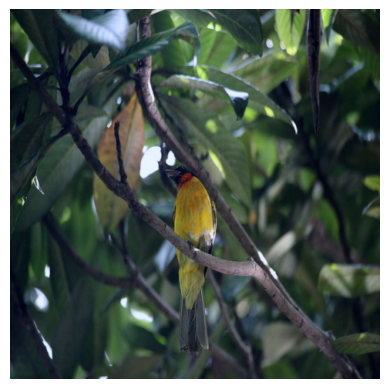

In [4]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

## Load a model

In [5]:
# Access denied by Google Drive and the snippet could not be run. 
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs)
    return keras.Model(inputs, outputs=[outputs, attention_weights])


def get_model(url_or_id):
    if "https" in url_or_id:
        loaded_model = get_tfhub_model(url_or_id)
    else:
        loaded_model = get_gdrive_model(url_or_id)
    return loaded_model


vit_base_i21k_patch16_224 = get_model("1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ")
print("Model loaded.")

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ 



AttributeError: 'NoneType' object has no attribute 'seek'

**More about the model**:

This model was pretrained on the ImageNet-21k dataset and was then fine-tuned on the
ImageNet-1k dataset. To learn more about how we developed this model in TensorFlow
(with pretrained weights from
[this source](https://github.com/google-research/vision_transformer/)) refer to
[this notebook](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/load-jax-weights-vitb16.ipynb).

## Running regular inference with the model

We now run inference with the loaded model on our test image.

In [0]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

`attention_score_dict` contains the attention scores (softmaxed outputs) from each
attention head of each Transformer block.

## Method I: Mean attention distance

[Dosovitskiy et al.](https://arxiv.org/abs/2010.11929) and
[Raghu et al.](https://arxiv.org/abs/2108.08810) use a measure called
"mean attention distance" from each attention head of different
Transformer blocks to understand how local and global information flows
into Vision Transformers.

Mean attention distance is defined as the distance between query tokens and the other
tokens times attention weights. So, for a single image

* we take individual patches (tokens) extracted from the image,
* calculate their geometric distance, and
* multiply that with the attention scores.

Attention scores are calculated here after forward passing the image in inference mode
through the network. The following figure may help you  understand the process a
little bit better.

<img src="https://i.imgur.com/pZCgPwl.gif" height=500>

This animation is created by [Ritwik Raha](https://twitter.com/ritwik_raha).

In [0]:

def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances


Thanks to [Simon Kornblith](https://scholar.google.com/citations?user=1O3RPmsAAAAJ&hl=en)
from Google who helped us with this code snippet. It can be found
[here](https://gist.github.com/simonster/155894d48aef2bd36bd2dd8267e62391). Let's now use
these utilities to generate a plot of attention distances with our loaded model and test
image.

In [0]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

### Inspecting the plots

**How does self-attention span across the input space? Do they attend
input regions locally or globally?**

The promise of self-attention is to enable the learning of contextual dependencies
so that a model can attend to the regions of inputs which are the most salient w.r.t
the objective. From the above plots we can notice that different attention heads yield
different attention distances suggesting they use both local and global information
from an image. But as we go deeper in the Transformer blocks the heads tend to
focus more on global aggregate information.

Inspired by [Raghu et al.](https://arxiv.org/abs/2108.08810) we computed mean attention
distances over 1000 images randomly taken from the ImageNet-1k validation set and we
repeated the process for all the models mentioned at the beginning. Intrestingly, we
notice the following:

* Pretraining with a larger dataset helps with more global attention spans:


| Pretrained on ImageNet-21k<br>Fine-tuned on ImageNet-1k | Pretrained on ImageNet-1k |
| :--: | :--: |
| ![](https://drive.google.com/uc?export=view&id=1aFob5Cj0FkRyVhH4Iw7Dh5SFxQH3rpYs) | ![](https://drive.google.com/uc?export=view&id=13Y-3Ypi58PPRqd-pqP1oHkyNkRHCYypH) |


* When distilled from a CNN ViTs tend to have less global attention spans:


| No distillation (ViT B-16 from DeiT) | Distilled ViT B-16 from DeiT |
| :--: | :--: |
| ![](https://drive.google.com/uc?export=view&id=1yH4cPQcMFCnuo3-IW3S9Baszr_d0o2Se) | ![](https://drive.google.com/uc?export=view&id=1m_nG12kq7E_zIEkxhsi7U0Xr_VDXhJYE) |

To reproduce these plots, please refer to
[this notebook](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/mean-attention-distance-1k.ipynb).

## Method II: Attention Rollout

[Abnar et al.](https://arxiv.org/abs/2005.00928) introduce "Attention rollout" for
quantifying how information flow through self-attention layers of Transformer blocks.
Original ViT authors use this method to investigate the learned representations, stating:

> Briefly, we averaged attention weights of ViTL/16 across all heads and then recursively
multiplied the weight matrices of all layers. This accounts for the mixing of attention
across tokens through all layers.

We used
[this notebook](https://colab.research.google.com/github/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)
and modified the attention rollout code from it for compatibility with our models.

In [0]:

def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result


Let's now use these utilities to generate an attention plot based on our previous results
from the "Running regular inference with the model" section. Following are the links to
download each individual model:

* [Original ViT model (pretrained on ImageNet-21k)](https://drive.google.com/file/d/1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ/view?usp=sharing)
* [Original ViT model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7/view?usp=sharing)
* [DINO model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN/view?usp=sharing)
* [DeiT models (pretrained on ImageNet-1k including distilled and non-distilled ones)](https://tfhub.dev/sayakpaul/collections/deit/1)

In [0]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

### Inspecting the plots

**How can we quanitfy the information flow that propagates through the
attention layers?**

We notice that the model is able to focus its attention on the
salient parts of the input image. We encourage you to apply this
method to the other models we mentioned and compare the results. The
attention rollout plots will differ according to the tasks and
augmentation the model was trained with. We observe that DeiT has the
best rollout plot, likely due to its augmentation regime.

## Method III: Attention heatmaps

A simple yet useful way to probe into the representation of a Vision Transformer is to
visualise the attention maps overlayed on the input images. This helps form an intuition
about what the model attends to. We use the DINO model for this purpose, because it
yields better attention heatmaps.

In [0]:
# Load the model.
vit_dino_base16 = get_model("16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN")
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = vit_dino_base16.predict(preprocessed_image)

A Transformer block consists of multiple heads. Each head in a Transformer block projects
the input data to different sub-spaces. This helps each individual head to attend to
different parts of the image. Therefore, it makes sense to visualize each attention head
map seperately, to make sense of what each heads looks at.

**Notes**:

* The following code has been copy-modified from the
[original DINO codebase](https://github.com/facebookresearch/dino/blob/main/visualize_attention.py).
* Here we grab the attention maps of the last Transformer block.
* [DINO](https://arxiv.org/abs/2104.14294) was pretrained using a self-supervised
objective.

In [0]:

def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions


We can use the same image we used for inference with DINO and the `attention_score_dict`
we extracted from the results.

In [0]:
# De-normalize the image for visual clarity.
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

### Inspecting the plots

**How can we qualitatively evaluate the attention weights?**

The attention weights of a Transformer block are computed between the
key and the query. The weights quantifies how important is the key to the query.
In the ViTs the key and the query comes from the same image, hence
the weights determine which part of the image is important.

Plotting the attention weigths overlayed on the image gives us a great
intuition about the parts of the image that are important to the Transformer.
This plot qualitatively evaluates the purpose of the attention weights.

## Method IV: Visualizing the learned projection filters

After extracting non-overlapping patches, ViTs flatten those patches across their
saptial dimensions, and then linearly project them. One might wonder, how do these
projections look like? Below, we take the ViT B-16 model and visualize its
learned projections.

In [0]:
# Extract the projections.
projections = (
    vit_base_i21k_patch16_224.layers[1]
    .get_layer("projection")
    .get_layer("conv_projection")
    .kernel.numpy()
)
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]

# Scale the projections.
scaled_projections = MinMaxScaler().fit_transform(
    projections.reshape(-1, projection_dim)
)

# Reshape the scaled projections so that the leading
# three dimensions resemble an image.
scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)

# Visualize the first 128 filters of the learned
# projections.
fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()

### Inspecting the plots

**What do the projection filters learn?**

[When visualized](https://distill.pub/2017/feature-visualization/),
the kernels of a convolutional neural network show
the pattern that they look for in an image. This could be circles,
sometimes lines -- when combined together (in later stage of a ConvNet), the filters
transform into more complex shapes. We have found a stark similarity between such
ConvNet kernels and the projection filters of a ViT.

## Method V: Visualizing the positional emebddings

Transformers are permutation-invariant. This means that do not take into account
the spatial position of the input tokens. To overcome this
limitation, we add positional information to the input tokens.

The positional information can be in the form of leaned positional
embeddings or handcrafted constant embeddings. In our case, all the
three variants of ViTs feature learned positional embeddings.

In this section, we visualize the similarities between the
learned positional embeddings with itself. Below, we take the ViT B-16
model and visualize the similarity of the positional embeddings by
taking their dot-product.

In [0]:
position_embeddings = vit_base_i21k_patch16_224.layers[1].positional_embedding.numpy()

# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()

### Inspecting the plots

**What do the positional embeddings tell us?**

The plot has a distinctive diagonal pattern. The main diagonal is the brightest
signifying that a position is the most similar to itself. An interesting
pattern to look out for is the repeating diagonals. The repeating pattern
portrays a sinusoidal function which is close in essence to what was proposed by
[Vaswani et. al.](https://arxiv.org/abs/1706.03762) as a hand-crafted feature.

## Notes

* DINO extended the attention heatmap generation process to videos. We also
[applied](https://github.com/sayakpaul/probing-vits/blob/main/notebooks/dino-attention-map
s-video.ipynb) our DINO implementation on a series of videos and obtained similar
results. Here's one such video of attention heatmaps:

  ![dino](https://i.imgur.com/kAShjbs.gif)

* [Raghu et al.](https://arxiv.org/abs/2108.08810) use an array of techniques to
investigate the representations learned by ViTs and make comparisons with that of
ResNets. We strongly recommend reading their work.

* To author this example, we developed
[this repository](https://github.com/sayakpaul/probing-vits) to guide our readers so that they
can easily reproduce the experiments and extend them.

* Another repository that you may find interesting in this regard is
[`vit-explain`](https://github.com/jacobgil/vit-explain).

* One can also plot the attention rollout and attention heat maps with
custom images using our Hugging Face spaces.

| Attention Heat Maps | Attention Rollout |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-Attention%20Heat%20Maps-black.svg)](https://huggingface.co/spaces/probing-vits/attention-heat-maps) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-Attention%20Rollout-black.svg)](https://huggingface.co/spaces/probing-vits/attention-rollout) |

## Acknowledgements

- [PyImageSearch](https://pyimagesearch.com)
- [Jarvislabs.ai](https://jarvislabs.ai/)
- [GDE Program](https://developers.google.com/programs/experts/)